# Matt Manner [xkv3na@virginia.edu]
## DS 5001
### 3 Apr 23

### 1.1 First things first, import packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
import plotly_express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.lda_model
from gensim.models import word2vec
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

/Users/mattmanner/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### 1.2 Import and Parse Data

In [2]:
## Reading in data and formatting the text

chunk_pat = '\n\n'
LINES = pd.DataFrame(open('Shakespeare_Corpus.txt', 'r').read().split(chunk_pat))
LINES.columns = ['line_str']
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace('\n+', ' ', regex=True).str.strip()
OHCO = ['book_id', 'act_num', 'scene_num', 'para_num', 'token_num']

#### There are a ton of 'non-plays' in Shakespeare's corpus (e.g. The Sonnets is just a collection of poems). I want to ensure consistent OHCO, so will take a subset of his works, particularly his most famous plays like Romeo and Juliet, Macbeth (my personal favorite), Hamlet, and Othello.

In [3]:
# This is the full list of works in the Shakespeare text doc

full_list_of_works = [
    'THE SONNETS',
    'ALL’S WELL THAT ENDS WELL',
    'THE TRAGEDY OF ANTONY AND CLEOPATRA',
    'AS YOU LIKE IT',
    'THE COMEDY OF ERRORS',
    'THE TRAGEDY OF CORIOLANUS',
    'CYMBELINE',
    'THE TRAGEDY OF HAMLET, PRINCE OF DENMARK',
    'THE FIRST PART OF KING HENRY THE FOURTH',
    'THE SECOND PART OF KING HENRY IV',# this one doesn't appear as a second title
    'THE LIFE OF KING HENRY THE FIFTH',
    'THE FIRST PART OF HENRY THE SIXTH',
    'THE SECOND PART OF KING HENRY THE SIXTH', 
    'THE THIRD PART OF KING HENRY THE SIXTH',
    'KING HENRY THE EIGHTH',
    'THE LIFE AND DEATH OF KING JOHN',
    'THE TRAGEDY OF JULIUS CAESAR',
    'THE TRAGEDY OF KING LEAR',
    'LOVE’S LABOUR’S LOST',
    'THE TRAGEDY OF MACBETH',
    'MEASURE FOR MEASURE',
    'THE MERCHANT OF VENICE',
    'THE MERRY WIVES OF WINDSOR',
    'A MIDSUMMER NIGHT’S DREAM',
    'MUCH ADO ABOUT NOTHING',
    'THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE',
    'PERICLES, PRINCE OF TYRE',
    'THE LIFE AND DEATH OF KING RICHARD THE SECOND',
    'KING RICHARD THE THIRD',
    'THE TRAGEDY OF ROMEO AND JULIET',
    'THE TAMING OF THE SHREW',
    'THE TEMPEST',
    'THE LIFE OF TIMON OF ATHENS',
    'THE TRAGEDY OF TITUS ANDRONICUS',
    'TROILUS AND CRESSIDA',
    'TWELFTH NIGHT; OR, WHAT YOU WILL',
    'THE TWO GENTLEMEN OF VERONA',
    'THE TWO NOBLE KINSMEN',
    'THE WINTER’S TALE',
    'A LOVER’S COMPLAINT',
    'THE PASSIONATE PILGRIM',
    'THE PHOENIX AND THE TURTLE',
    'THE RAPE OF LUCRECE',
    'VENUS AND ADONIS']

In [4]:
# I only want to analyze these texts 

list_of_works = [
    'ALL’S WELL THAT ENDS WELL',
    'THE TRAGEDY OF ANTONY AND CLEOPATRA',
    'THE COMEDY OF ERRORS',
    'CYMBELINE',
    'THE TRAGEDY OF HAMLET, PRINCE OF DENMARK',
    'THE FIRST PART OF KING HENRY THE FOURTH',
    'THE SECOND PART OF KING HENRY IV',
    'THE FIRST PART OF HENRY THE SIXTH',
    'THE SECOND PART OF KING HENRY THE SIXTH', 
    'THE THIRD PART OF KING HENRY THE SIXTH',
    'THE LIFE AND DEATH OF KING JOHN',
    'THE TRAGEDY OF JULIUS CAESAR',
    'THE TRAGEDY OF KING LEAR',
    'THE TRAGEDY OF MACBETH',
    'THE MERCHANT OF VENICE',
    'A MIDSUMMER NIGHT’S DREAM',
    'THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE',
    'THE TRAGEDY OF ROMEO AND JULIET']

### 1.3 Remove extraneous lines from the data

In [5]:
# Clipping the text to get rid of the copyright stuff

clip_pats = [
    r"\*\*\*\s*START OF (?:THE|THIS) PROJECT", 
    r"\*\*\*\s*END OF (?:THE|THIS) PROJECT"
]
pat_a = LINES.line_str.str.match(clip_pats[0])
pat_b = LINES.line_str.str.match(clip_pats[1])
line_a = LINES.loc[pat_a].index[0] + 1
line_b = LINES.loc[pat_b].index[0] - 1
LINES = LINES.loc[line_a : line_b]

#### The corpus is arranged as one giant text file- there is a table of contents, and then the plays are just consecutively listed. I want to parse each play and its OHCO separately, so need to have a way of delimiting them!

In [6]:
# Getting first appearance of each title (that's where books are parsed)

book_line_nums = []
for title in full_list_of_works:
    book_line_nums.append(LINES.line_str[LINES.line_str == title].index)

book_lines_list = []
for ind in range(len(book_line_nums)):
    book_lines_list.append(book_line_nums[ind][0])


In [7]:
# The next line gives a Boolean for each line; True or False depending on if it's the first occurence of each play's title
book_lines = pd.Series(LINES.index.isin(book_lines_list)) # Returns a truth vector

# Finding lines that are the beginning of each play, and forward filling
LINES.loc[book_lines_list, 'book_id'] = [i for i in range(LINES.loc[book_lines_list].shape[0])]
LINES.book_id = LINES.book_id.ffill()

In [8]:
# Delete everything before book 1
LINES = LINES.dropna(subset=['book_id'])

In [9]:
# Only want to keep books in list_of_works (the subset).
# The following gives the index in the full book list for the given book in the subset ( as they are not
# necessarily consecutive in the corpus)

desired_books = []
for book in list_of_works:
    desired_books.append(full_list_of_works.index(book))
desired_books

[1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19, 21, 23, 25, 29]

In [10]:
# Removing undesired books; any book where book id isn't in desired_books needs to go

LINES['book_id'] = LINES['book_id'].astype(int)
LINES = LINES[LINES['book_id'].isin(desired_books)]

In [11]:
# I will split the corpus by book for individual parsing, then rejoin them
# This is much easier

len(desired_books) # Gives number of books I need to split into, = 18

# The following lines are for re-numbering the books to be from 0-17 (18 total books).
# This will make it much easier to apply functions in loops for the corpus.

books_dict = dict(zip(desired_books, range(len(desired_books))))
LINES["book_id"] = LINES["book_id"].apply(lambda x: books_dict.get(x))

### 1.4 Parsing by OHCO

#### I will split LINES by book, and make each book a separate Pandas DataFrame. That way, I can perform operations on them (parsing, etc.) and then combine to reconstruct the corpus.

In [12]:
books = dict()
for i in range(len(desired_books)):
    books[i] = LINES[LINES['book_id'] == i]

In [13]:
# Replace book_id field with the title for ease of use

books_list = dict(zip(range(len(list_of_works)), list_of_works))

In [14]:
# Warnings are annoying
warnings.filterwarnings("ignore")

# Running a loop for each dataframe (i.e. each book):
for book in range(len(books)):
    
    # Finding lines that contain ACT I and deleting anything before
    act_lines = books[book].line_str.str.contains(r'\bACT I\b') # Returns a truth vector
    
    # Labeling lines that are the beginnings of each ACT (the actual ACT header)
    books[book].loc[act_lines, 'act_num'] = [i for i in range(books[book].loc[act_lines].shape[0])]
    # Forward filling ACT
    books[book].act_num = books[book].act_num.ffill()
    
    books[book] = books[book].dropna(subset=['act_num']) # Remove everything before Act 1
    books[book] = books[book][books[book]['act_num'] > 0]
    
    # Similar to the work I did on books before, now just with ACTS
    # This is to actually number the ACTS
    act_lines2 = books[book].line_str.str.contains(r'\bACT\b') # Returns a truth vector
    books[book].loc[act_lines2, 'act_num2'] = [i+1 for i in range(books[book].loc[act_lines2].shape[0])]
    books[book].act_num2 = books[book].act_num2.ffill()
    books[book] = books[book].drop('act_num', axis=1)
    
    # Need to rename column
    books[book].rename(columns = {'act_num2':'act_num'}, inplace = True)
    
    # Remove ACT headers, they are undesirable to include in the DF
    act_lines3 = ~books[book].line_str.str.contains(r'\bACT\b') # Remove ACT headers
    books[book] = books[book][act_lines3]
    
    # Now doing the same for SCENE, but don't need to delete pre-scene 1 like I did for ACT
    # Since ACT 1 always begins with SCENE 1
    scene_lines = books[book].line_str.str.contains(r'\bSCENE\b') # Returns a truth vector
    books[book].loc[scene_lines, 'scene_num'] = [i+1 for i in range(books[book].loc[scene_lines].shape[0])]
    books[book].scene_num = books[book].scene_num.ffill()
    scene_lines3 = ~books[book].line_str.str.contains(r'\bSCENE\b') # Remove SCENE headers
    books[book] = books[book][scene_lines3]
    
    # Replace book_id numeric field with book title
    books[book]["book_id"] = books[book]["book_id"].apply(lambda x: books_list.get(x))

In [15]:
# Taking a look at books
# This is for the first book dataframe (All's Well That Ends Well)
books[0].sample(5)

line_str  \
line_num                                                      
494       HELENA. I will tell truth; by grace itself I s...   
1144                 PAROLLES. Poor rogues, I pray you say.   
1104      SECOND LORD. I am heartily sorry that he’ll be...   
549                                         [_Exit Lafew._]   
1048                                 A short alarum within.   

                            book_id  act_num  scene_num  
line_num                                                 
494       ALL’S WELL THAT ENDS WELL      1.0        3.0  
1144      ALL’S WELL THAT ENDS WELL      4.0       18.0  
1104      ALL’S WELL THAT ENDS WELL      4.0       18.0  
549       ALL’S WELL THAT ENDS WELL      2.0        4.0  
1048      ALL’S WELL THAT ENDS WELL      4.0       16.0

In [16]:
ACTS = dict()
SCENES = dict()
# Split into 1 string for each act/scene

for book in range(len(books)):
    
    ACTS[book] = books[book].groupby('act_num').line_str.apply(
    lambda x: '\n'.join(x)).to_frame('act_str') # Make each ACT into its own string
    
    # Adding in a book ID column for the recombined DataFrame
    ACTS[book]['book_id'] = list_of_works[book]
    ACTS[book] = ACTS[book].reset_index()
    ACTS[book].set_index(['book_id', 'act_num'], inplace = True,
                            append = True, drop = True)
    
    # Same thing for SCENES
    SCENES[book] = books[book].groupby(['act_num','scene_num']).line_str.apply(
    lambda x: '\n'.join(x)).to_frame('scene_str').replace(r'\n', ' ', regex=True) # Make big string for each SCENE
    # Adding in a book ID column for rejoining works
    SCENES[book]['book_id'] = list_of_works[book]
    SCENES[book] = SCENES[book].reset_index()
    SCENES[book].set_index(['book_id', 'act_num', 'scene_num'], inplace = True,
                            append = True, drop = True)
    

#### Recombining individual book DataFrames to make one big one for the corpus. I will have a "complete corpus" set for individual lines, scenes, and acts.

In [17]:
# For concatenating books, scenes, and acts since I want the whole corpus together.
list_of_book_frames = []
scenes_list = []
acts_list = []
for i in range(len(list_of_works)):
    list_of_book_frames.append(books[i])  # List of your dataframes
    scenes_list.append(SCENES[i])
    acts_list.append(ACTS[i])

In [18]:
# Concatenating
complete_works_lines = pd.concat(list_of_book_frames)
complete_works_scenes = pd.concat(scenes_list)
complete_works_acts = pd.concat(acts_list)

### 2.1 Tokenizing by hand

In [19]:
sent_pat = r'[.?!;:]+'
SENTS = complete_works_scenes['scene_str'].str.split(sent_pat, expand=True).stack()\
    .to_frame('sent_str').reset_index()

SENTS.rename(columns = {'level_4':'sent_num'}, inplace = True)
SENTS = SENTS.drop(['level_0'], axis=1)
SENTS = SENTS.set_index(['book_id', 'act_num', 'scene_num', 'sent_num'])

In [20]:
SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs
SENTS.sent_str = SENTS.sent_str.str.strip() # CRUCIAL TO REMOVE BLANK TOKENS

In [21]:
token_pat = r"[\s',-]+"
TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
    .to_frame('token_str')

In [22]:
TOKENS

token_str
book_id                         act_num scene_num sent_num             
ALL’S WELL THAT ENDS WELL       1.0     1.0       0        0      Enter
                                                           1    Bertram
                                                           2        the
                                                           3   Countess
                                                           4         of
...                                                                 ...
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      339      19       and
                                                           20       her
                                                           21     Romeo
                                                  340      0   [_Exeunt
                                                  341      0         _]

[436665 rows x 1 columns]

### Get vocab- also will be automated w/ NLTK.

In [23]:
# Getting vocab table
TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower()
VOCAB2 = TOKENS.term_str.value_counts().to_frame('n').reset_index().rename(columns={'index':'term_str'})
VOCAB2.index.name = 'term_id'

### 2.2 Initial Exploratory Data Analysis

#### Plotting book length by number of terms- interesting to see that most of his plays are around the same length

Text(0, 0.5, 'Play Title')

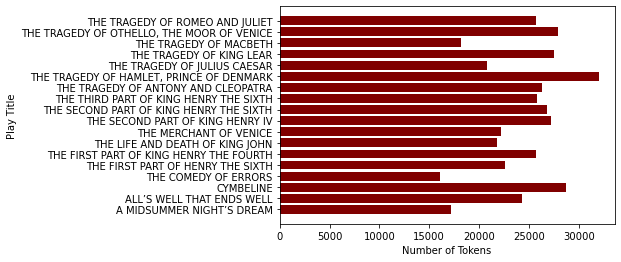

In [24]:
plt.barh(TOKENS.reset_index().groupby('book_id').agg('count').drop(['act_num', 'scene_num', 'sent_num', 'level_4', 'token_str'], axis = 1).reset_index()['book_id'], 
        TOKENS.reset_index().groupby('book_id').agg('count').drop(['act_num', 'scene_num', 'sent_num', 'level_4', 'token_str'], axis = 1)['term_str'], color ='maroon',
        )
plt.xlabel("Number of Tokens")
plt.ylabel("Play Title")

#### All his plays have 5 acts! Did not know that

In [25]:
TOKENS.reset_index().groupby('book_id').agg({'act_num':'nunique'})

act_num
book_id                                            
A MIDSUMMER NIGHT’S DREAM                         5
ALL’S WELL THAT ENDS WELL                         5
CYMBELINE                                         5
THE COMEDY OF ERRORS                              5
THE FIRST PART OF HENRY THE SIXTH                 5
THE FIRST PART OF KING HENRY THE FOURTH           5
THE LIFE AND DEATH OF KING JOHN                   5
THE MERCHANT OF VENICE                            5
THE SECOND PART OF KING HENRY IV                  5
THE SECOND PART OF KING HENRY THE SIXTH           5
THE THIRD PART OF KING HENRY THE SIXTH            5
THE TRAGEDY OF ANTONY AND CLEOPATRA               5
THE TRAGEDY OF HAMLET, PRINCE OF DENMARK          5
THE TRAGEDY OF JULIUS CAESAR                      5
THE TRAGEDY OF KING LEAR                          5
THE TRAGEDY OF MACBETH                            5
THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE        5
THE TRAGEDY OF ROMEO AND JULIET                   5

#### Number of scenes varies widely between plays, however

Text(0, 0.5, 'Play Title')

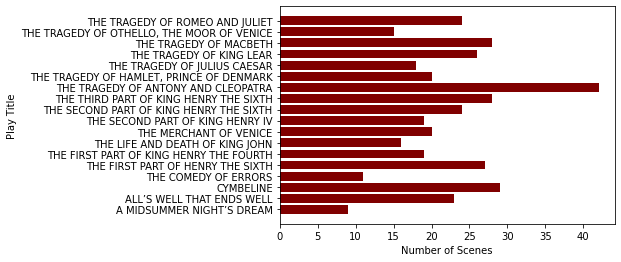

In [26]:
TOKENS.reset_index().groupby('book_id').agg({'scene_num':'nunique'})
plt.barh(TOKENS.reset_index().groupby('book_id').agg({'scene_num':'nunique'}).reset_index()['book_id'], 
        TOKENS.reset_index().groupby('book_id').agg({'scene_num':'nunique'})['scene_num'], color ='maroon',
        )
plt.xlabel("Number of Scenes")
plt.ylabel("Play Title")

### 2.3 Make LIB table

In [27]:
libdict = dict(zip(range(len(list_of_works)), list_of_works))

In [28]:
LIB = pd.DataFrame(libdict.items())

In [29]:
LIB = LIB.drop([0], axis=1)
LIB.rename(columns = {1:'title'}, inplace = True)

In [30]:
LIB

title
0                    ALL’S WELL THAT ENDS WELL
1          THE TRAGEDY OF ANTONY AND CLEOPATRA
2                         THE COMEDY OF ERRORS
3                                    CYMBELINE
4     THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
5      THE FIRST PART OF KING HENRY THE FOURTH
6             THE SECOND PART OF KING HENRY IV
7            THE FIRST PART OF HENRY THE SIXTH
8      THE SECOND PART OF KING HENRY THE SIXTH
9       THE THIRD PART OF KING HENRY THE SIXTH
10             THE LIFE AND DEATH OF KING JOHN
11                THE TRAGEDY OF JULIUS CAESAR
12                    THE TRAGEDY OF KING LEAR
13                      THE TRAGEDY OF MACBETH
14                      THE MERCHANT OF VENICE
15                   A MIDSUMMER NIGHT’S DREAM
16  THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
17             THE TRAGEDY OF ROMEO AND JULIET

### 2.4 NLTK Parsing to make TOKENS and VOCAB tables

In [31]:
sample_sent = SENTS.iloc[4].sent_str

In [32]:
sample_tokens = nltk.word_tokenize(sample_sent)

In [33]:
sample_tagged_tokens = nltk.pos_tag(nltk.word_tokenize(sample_sent))

In [34]:
keep_whitespace = True
if keep_whitespace:
    TOKENS2 = SENTS.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')
else:
    TOKENS2 = SENTS.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')

In [35]:
# Separating out
TOKENS2['pos'] = TOKENS2.pos_tuple.apply(lambda x: x[1])
TOKENS2['token_str'] = TOKENS2.pos_tuple.apply(lambda x: x[0])
TOKENS2['term_str'] = TOKENS2.token_str.str.lower()

In [36]:
# Taking out punctuation from CORPUS
# List of punctuations: , ( ) [ ] & ‘ _ ’ ” “ …
punctuations = [',', '(', ')', '[', ']', '&', "‘" ,'_' ,"’" ,'”', '“', "…"]
TOKENS2 = TOKENS2[~TOKENS2.term_str.isin(punctuations)]


In [37]:
TOKENS2.index.rename(['book_id', 'act_num', 'scene_num', 'sent_num', 'token_num'], inplace=True)

In [38]:
VOCAB = TOKENS2.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['max_pos'] = TOKENS2[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos'] = TOKENS2[['term_str','pos']].value_counts().unstack().count(1)

#### Stemming

In [39]:
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

#### Stopwords

In [40]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [41]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [42]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [43]:
pd.concat([a,b], axis=1)

n_chars     n_pos
stop                    
0     7.311192  1.618166
1     3.777778  3.377778

### 3.1 Significance Metrics

In [44]:
tf_method = 'sum'         # sum, max, log, double_norm, raw, binary
tf_norm_k = .5            # only used for double_norm
idf_method = 'standard'   # standard, max, smooth
gradient_cmap = 'YlGnBu'  # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

OHCO = ['book_id', 'act_num', 'scene_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
SCENES = OHCO[:3]
ACTS = OHCO[:2]
BOOKS = OHCO[:1]
bag = SCENES

In [45]:
CORPUS = TOKENS2

In [204]:
CORPUS

pos_tuple  \
book_id                         act_num scene_num sent_num token_num                    
ALL’S WELL THAT ENDS WELL       1.0     1.0       0        0             (Enter, NNP)   
                                                           1           (Bertram, NNP)   
                                                           3                (the, DT)   
                                                           4          (Countess, NNP)   
                                                           5                 (of, IN)   
...                                                                               ...   
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      339      22           (Juliet, NNP)   
                                                           23               (and, CC)   
                                                           24             (her, PRP$)   
                                                           25             (Romeo, NN)   
                                                  340      1            (_Exeunt, NN)   

                                                                       pos  \
book_id                         act_num scene_num sent_num token_num         
ALL’S WELL THAT ENDS WELL       1.0     1.0       0        0           NNP   
                                                           1           NNP   
                                                           3            DT   
                                                           4           NNP   
                                                           5            IN   
...                                                                    ...   
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      339      22          NNP   
                                                           23           CC   
                                                           24         PRP$   
                                                           25           NN   
                                                  340      1            NN   

                                                                     token_str  \
book_id                         act_num scene_num sent_num token_num             
ALL’S WELL THAT ENDS WELL       1.0     1.0       0        0             Enter   
                                                           1           Bertram   
                                                           3               the   
                                                           4          Countess   
                                                           5                of   
...                                                                        ...   
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      339      22           Juliet   
                                                           23              and   
                                                           24              her   
                                                           25            Romeo   
                                                  340      1           _Exeunt   

                                                                      term_str  
book_id                         act_num scene_num sent_num token_num            
ALL’S WELL THAT ENDS WELL       1.0     1.0       0        0             enter  
                                                           1           bertram  
                                                           3               the  
                                                           4          countess  
                                                           5                of  
...                                                                        ...  
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      339      22           juliet  
                                                           23              and  
                          

In [242]:
# Adding token_num to CORPUS index
CORPUS = CORPUS.reset_index().rename(columns = {'level_4':'token_num'}).set_index(OHCO)

In [243]:
# Making Bag of Words
bag = BOOKS
BOW_BOOKS = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n') 
bag = SCENES
BOW_SCENES = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n') 

In [244]:
# DTCM
DTCM = BOW_BOOKS.n.unstack().fillna(0).astype('int')
bag = BOOKS
DOCS = BOW_BOOKS.groupby(bag).n.sum().to_frame('n')

In [245]:
# TDIDF Function
def tfidf(df, method):
    DTCM = df.n.unstack().fillna(0).astype('int')
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T
    DF = DTCM.astype('bool').sum()
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    TFIDF = TF * IDF
    df['tf'] = TF.stack()
    df['tfidf'] = TFIDF.stack()
    return df

In [246]:
# Why does every single term have an underscore before it...???
TFIDF = tfidf(BOW_BOOKS, 'sum')

In [247]:
tfidf(BOW_SCENES, 'sum')

n        tf  \
book_id                         act_num scene_num term_str                  
A MIDSUMMER NIGHT’S DREAM       1.0     1.0       _exit       4  0.002106   
                                                  a          27  0.014218   
                                                  abjure      1  0.000527   
                                                  according   1  0.000527   
                                                  adieu       1  0.000527   
...                                                          ..       ...   
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      yoke        1  0.000395   
                                                  yond        2  0.000790   
                                                  you         9  0.003553   
                                                  your        7  0.002764   
                                                  youth       4  0.001579   

                                                                tfidf  
book_id                         act_num scene_num term_str             
A MIDSUMMER NIGHT’S DREAM       1.0     1.0       _exit      0.001596  
                                                  a          0.000947  
                                                  abjure     0.003715  
                                                  according  0.002135  
                                                  adieu      0.001917  
...                                                               ...  
THE TRAGEDY OF ROMEO AND JULIET 5.0     24.0      yoke       0.001797  
                                                  yond       0.003737  
                                                  you        0.000527  
                                                  your       0.000697  
                                                  youth      0.003748  

[156101 rows x 3 columns]

### 3.2 TFIDF Analyses

In [248]:
TF = BOW_BOOKS.n.unstack(fill_value=0) # Document-Term Count Matrix
DF = TF.astype('bool').sum() 
N = len(DOCS)
IDF = np.log2(N/DF)      
TFIDF = TF * IDF
TFIDF_agg = TFIDF.sum()

In [249]:
tf_variants = {
    'raw': lambda tf: tf,
    'rel': lambda tf: (tf.T / tf.T.sum()).T,
    'max': lambda tf, alpha=.4: alpha + (1 - alpha) * (tf.T / tf.T.max()).T,
    'log': lambda tf: np.log2(1 + tf),
    'bool': lambda tf: tf.astype('bool').astype('int'),
    # 'sub': lambda tf: 1 + np.log2(tf)
}

In [250]:
tfidf_variants = {k: tf_variants[k](TF) * IDF for k, v in tf_variants.items()}

In [251]:
tfidf_sums = {k: v.sum().to_frame('sum_val') for k, v in tfidf_variants.items()}

In [252]:
SUMS = pd.concat([v.sort_values('sum_val', ascending=False).head(20).reset_index() 
    for v in tfidf_sums.values()], keys=tfidf_sums.keys(), axis=1)

#### Top 20 words in significance for each TFIDF method, for the whole corpus.
##### Expected to see so many character names dominating the top 20, will remove those for next analysis.

In [253]:
SUMS.style.background_gradient('YlGnBu')

### 3.3 Adding TFIDF to VOCAB

In [58]:
# Adding DF and IDF
VOCAB['df'] = DF
VOCAB['idf'] = IDF
VOCAB['dfidf'] = VOCAB.df * VOCAB.idf

In [59]:
# Adding aggregates
VOCAB['tfidf_mean'] = TFIDF.mean() 
VOCAB['tfidf_sum'] = TFIDF.sum()
VOCAB['tfidf_median'] = TFIDF.median()
VOCAB['tfidf_max'] = TFIDF.max()

In [60]:
VOCAB.sample(5)

n         p          i  n_chars max_pos  n_pos  stem_porter  \
term_str                                                                   
musk-cat     1  0.000002  18.756990        8      NN      1     musk-cat   
returned     2  0.000005  17.756990        8     VBD      2       return   
thrice-fair  1  0.000002  18.756990       11      JJ      1  thrice-fair   
supreme      3  0.000007  17.172027        7      JJ      1       suprem   
leanness     1  0.000002  18.756990        8      NN      1         lean   

            stem_snowball stem_lancaster  stop  df       idf     dfidf  \
term_str                                                                 
musk-cat         musk-cat       musk-cat     0   1  4.169925  4.169925   
returned           return         return     0   2  3.169925  6.339850   
thrice-fair   thrice-fair    thrice-fair     0   1  4.169925  4.169925   
supreme            suprem         suprem     0   3  2.584963  7.754888   
leanness             lean           lean     0   1  4.169925  4.169925   

             tfidf_mean  tfidf_sum  tfidf_median  tfidf_max  
term_str                                                     
musk-cat       0.231663   4.169925           0.0   4.169925  
returned       0.352214   6.339850           0.0   3.169925  
thrice-fair    0.231663   4.169925           0.0   4.169925  
supreme        0.430827   7.754888           0.0   2.584963  
leanness       0.231663   4.169925           0.0   4.169925

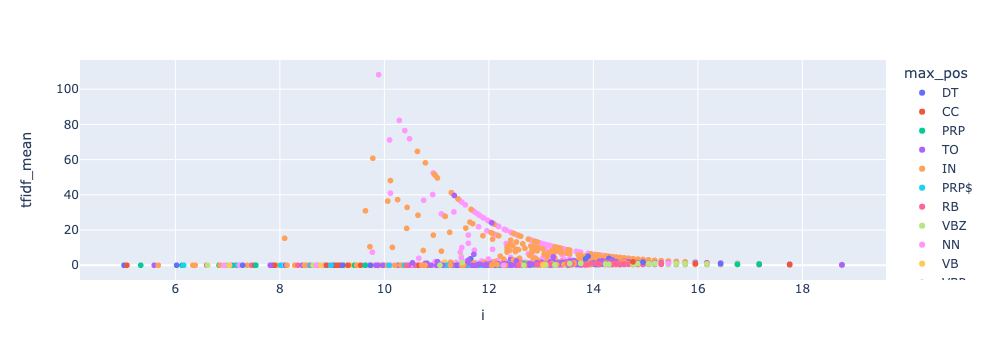

In [61]:
# Visualizing TFIDF
px.scatter(VOCAB.reset_index(), x='i', y='tfidf_mean', hover_name='term_str', hover_data=['n'], color = 'max_pos',  
           log_x=False, log_y=False)

### 4.1 Comparing Shakespeare's plays by similarity

In [62]:
# Recreating TFIDF, with sum method
get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))

In [63]:
bag = ACTS

In [64]:
BOW_ACTS = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n') 

In [65]:
TFIDF_ACT = get_tfidf(BOW_ACTS.n.unstack(fill_value=0))

In [66]:
# Aggregating
TFIDF_BOOK = TFIDF_ACT.groupby(OHCO[:1]).sum()

In [67]:
TFIDF_BOOK.head(5)

term_str                             1    2   2d   2s    3   4d   5s   6d  \
book_id                                                                     
A MIDSUMMER NIGHT’S DREAM          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ALL’S WELL THAT ENDS WELL          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
CYMBELINE                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
THE COMEDY OF ERRORS               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
THE FIRST PART OF HENRY THE SIXTH  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

term_str                            8d        _a  ...  —whiles  —who   —whose  \
book_id                                           ...                           
A MIDSUMMER NIGHT’S DREAM          0.0  0.000000  ...      0.0   0.0  0.00000   
ALL’S WELL THAT ENDS WELL          0.0  0.001039  ...      0.0   0.0  0.00116   
CYMBELINE                          0.0  0.000000  ...      0.0   0.0  0.00000   
THE COMEDY OF ERRORS               0.0  0.000000  ...      0.0   0.0  0.00000   
THE FIRST PART OF HENRY THE SIXTH  0.0  0.001871  ...      0.0   0.0  0.00000   

term_str                               —why  —with  —won  —yet  —you  —young  \
book_id                                                                        
A MIDSUMMER NIGHT’S DREAM          0.000000    0.0   0.0   0.0   0.0     0.0   
ALL’S WELL THAT ENDS WELL          0.000949    0.0   0.0   0.0   0.0     0.0   
CYMBELINE                          0.000000    0.0   0.0   0.0   0.0     0.0   
THE COMEDY OF ERRORS               0.000000    0.0   0.0   0.0   0.0     0.0   
THE FIRST PART OF HENRY THE SIXTH  0.000000    0.0   0.0   0.0   0.0     0.0   

term_str                              —your  
book_id                                      
A MIDSUMMER NIGHT’S DREAM          0.001986  
ALL’S WELL THAT ENDS WELL          0.000000  
CYMBELINE                          0.000000  
THE COMEDY OF ERRORS               0.001762  
THE FIRST PART OF HENRY THE SIXTH  0.000000  

[5 rows x 19104 columns]

#### Normalized tables

In [68]:
L0 = TFIDF_BOOK.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF_BOOK.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF_BOOK.apply(lambda x: x / norm(x), 1) # Pythagorean / Euclidean

#### Doc-pair tables

In [69]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

#### Compute distances

In [70]:
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
# PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [71]:
PAIRS

cityblock    euclidean    cosine   jaccard      dice        js
doc_a doc_b                                                                   
0     1      18375.713018  1435.559168  0.942508  0.761413  0.614744  0.729620
      2      22164.554836  1638.030822  0.997230  0.744507  0.593000  0.726525
      3      18111.014902  2024.546786  0.998980  0.757173  0.609235  0.752253
      4      21012.492957  1356.910720  0.997318  0.767713  0.622998  0.743661
      5      20708.710063  1286.307320  0.996349  0.763507  0.617478  0.738168
...                   ...          ...       ...       ...       ...       ...
14    16     25804.109048  2956.587746  0.998652  0.708095  0.548102  0.701002
      17     24424.716452  2302.641081  0.998340  0.724755  0.568326  0.710640
15    16     22878.784376  2912.762411  0.999102  0.726164  0.570061  0.718401
      17     21224.990343  2245.828218  0.998766  0.733071  0.578620  0.721263
16    17     25571.438262  3128.109624  0.999091  0.714616  0.555956  0.712475

[153 rows x 6 columns]

In [72]:
book_ids = LIB.title
book_numbs = list(range(18))

In [73]:
book_labs = []
for i in book_numbs:
    book_labs.append(str(i) + ' ' + book_ids[i])
LIB['label'] = book_labs

### 4.2 Producing dendrograms to visualize similarity between plays

In [74]:
# HCA Function
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.label
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=book_labs, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

#### All these methods seem to group Shakespeare's plays quite logically (ex: the multiple part plays are typically grouped closer than any other plays.

<Figure size 432x288 with 0 Axes>

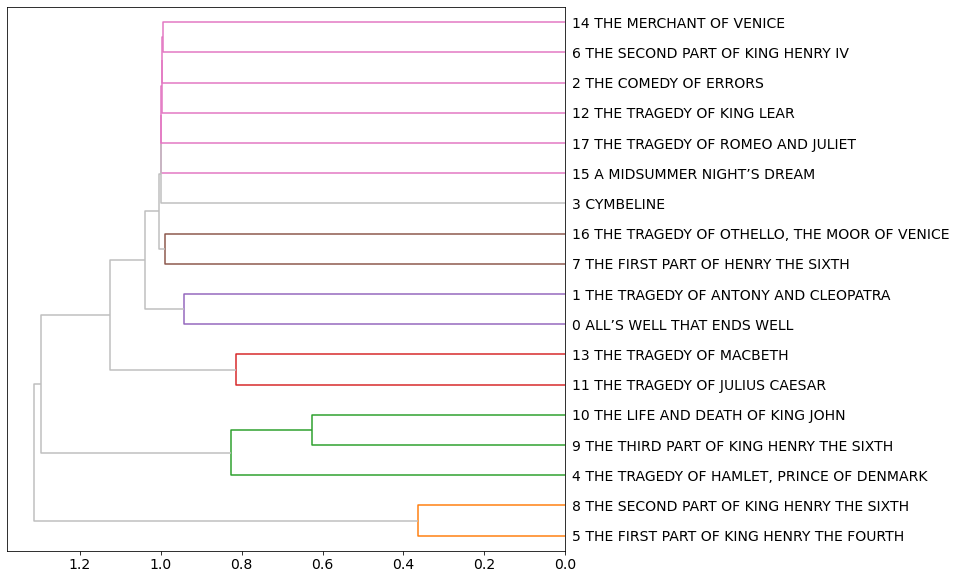

In [75]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=1)

<Figure size 432x288 with 0 Axes>

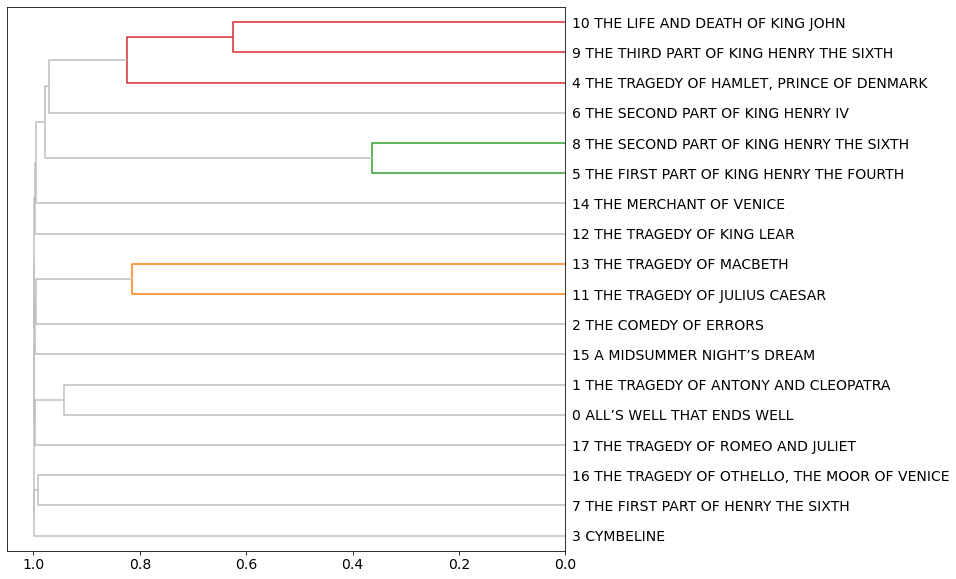

In [76]:
hca(PAIRS.cosine, linkage_method='complete', color_thresh=.9);

<Figure size 432x288 with 0 Axes>

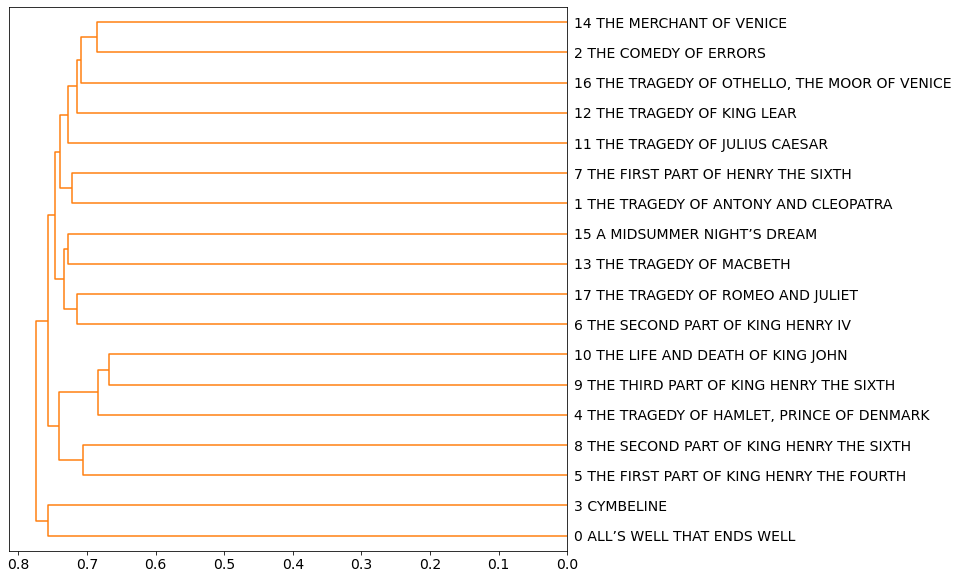

In [77]:
hca(PAIRS.jaccard, color_thresh=.8);

<Figure size 432x288 with 0 Axes>

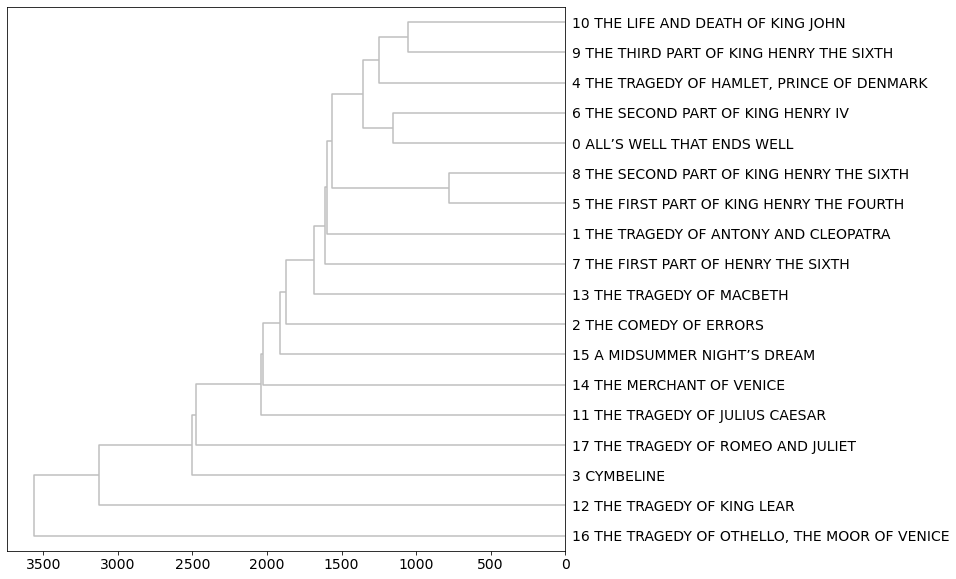

In [78]:
hca(PAIRS.euclidean, linkage_method='ward', color_thresh=80);

<Figure size 432x288 with 0 Axes>

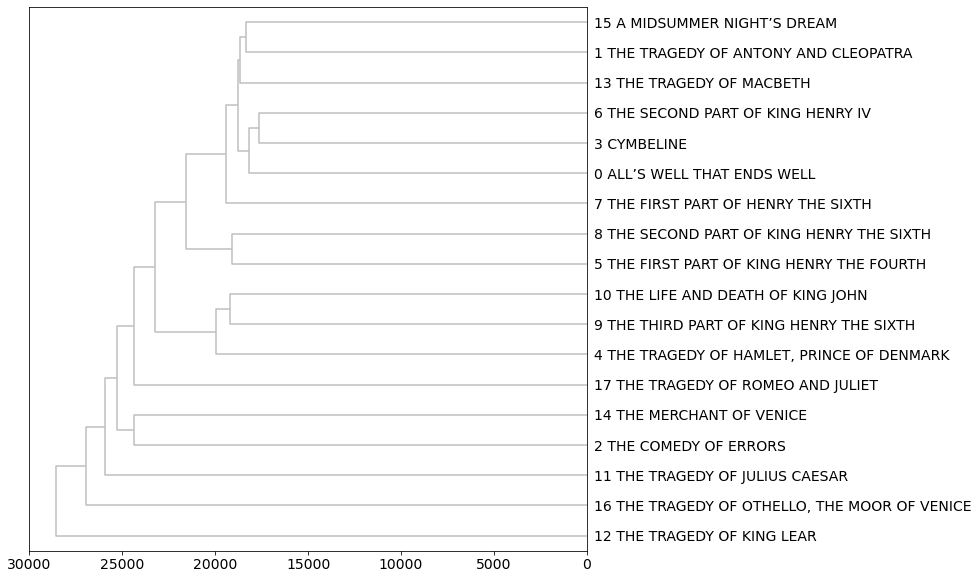

In [79]:
hca(PAIRS.cityblock, color_thresh=1300);

<Figure size 432x288 with 0 Axes>

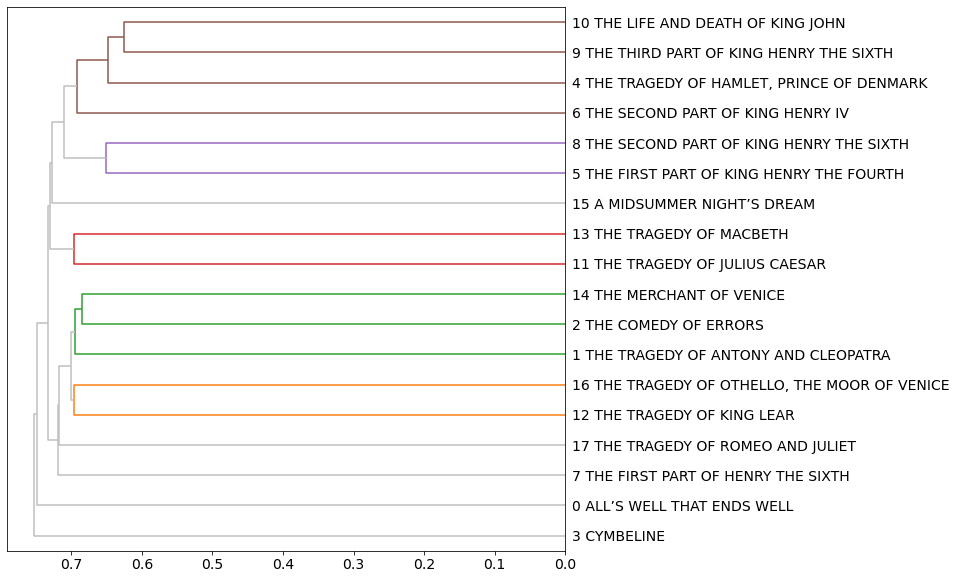

In [80]:
hca(PAIRS.js, color_thresh=.7);

## 5 Principal Component Analysis

### Data Manipulation

#### Reduce dimensionality by selecting top 1000 of nouns, verbs, and adjectives.

In [81]:
# Using TFIDF table from previous, with smaller group of words
VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'VB', 'JJ'])].sort_values('dfidf', ascending=False).head(1000)
TFIDF_SHORT = TFIDF_ACT[VSHORT.index]

In [82]:
TFIDF_SHORT

term_str                                 extremity   woeful  profession  \
book_id                         act_num                                   
A MIDSUMMER NIGHT’S DREAM       1.0       0.000000  0.00000         0.0   
                                2.0       0.000000  0.00000         0.0   
                                3.0       0.000573  0.00000         0.0   
                                4.0       0.000000  0.00000         0.0   
                                5.0       0.000000  0.00000         0.0   
...                                            ...      ...         ...   
THE TRAGEDY OF ROMEO AND JULIET 1.0       0.000517  0.00000         0.0   
                                2.0       0.000000  0.00000         0.0   
                                3.0       0.000000  0.00048         0.0   
                                4.0       0.000000  0.00565         0.0   
                                5.0       0.000000  0.00000         0.0   

term_str                                 ambassador  invention  funeral  \
book_id                         act_num                                   
A MIDSUMMER NIGHT’S DREAM       1.0             0.0        0.0  0.00000   
                                2.0             0.0        0.0  0.00000   
                                3.0             0.0        0.0  0.00000   
                                4.0             0.0        0.0  0.00000   
                                5.0             0.0        0.0  0.00000   
...                                             ...        ...      ...   
THE TRAGEDY OF ROMEO AND JULIET 1.0             0.0        0.0  0.00000   
                                2.0             0.0        0.0  0.00000   
                                3.0             0.0        0.0  0.00000   
                                4.0             0.0        0.0  0.00099   
                                5.0             0.0        0.0  0.00000   

term_str                                 proportion  champion  prosperous  \
book_id                         act_num                                     
A MIDSUMMER NIGHT’S DREAM       1.0        0.000000       0.0    0.000000   
                                2.0        0.000000       0.0    0.000000   
                                3.0        0.000000       0.0    0.000000   
                                4.0        0.000000       0.0    0.000000   
                                5.0        0.000000       0.0    0.000000   
...                                             ...       ...         ...   
THE TRAGEDY OF ROMEO AND JULIET 1.0        0.000000       0.0    0.000000   
                                2.0        0.000603       0.0    0.000000   
                                3.0        0.000505       0.0    0.000000   
                                4.0        0.000000       0.0    0.000899   
                                5.0        0.000000       0.0    0.000839   

term_str                                 prov  ...  arrest  taper      glow  \
book_id                         act_num        ...                            
A MIDSUMMER NIGHT’S DREAM       1.0       0.0  ...     0.0    0.0  0.000000   
                                2.0       0.0  ...     0.0    0.0  0.000000   
                                3.0       0.0  ...     0.0    0.0  0.000000   
                                4.0       0.0  ...     0.0    0.0  0.000000   
                                5.0       0.0  ...     0.0    0.0  0.001272   
...                                       ...  ...     ...    ...       ...   
THE TRAGEDY OF ROMEO AND JULIET 1.0       0.0  ...     0.0    0.0  0.000000   
                                2.0       0.0  ...     0.0    0.0  0.000000   
                                3.0       0.0  ...     0.0    0.0  0.000000   
                                4.0       0.0  ...     0.0    0.0  0.000000   
                                5.0       0.0  ...     0.0    0.0  0.000000   

term_str          

### Normalize doc vector lengths

We use L2 normalization, which scales documents by their pythagorean (Euclidean) length.

In [83]:
TFIDF_L2 = (TFIDF_SHORT.T / norm(TFIDF_SHORT, 2, axis=1)).T

#### Center the term vectors

We can take the column-wise means (the means for the _term_ vectors), but this alters the cosine angles between terms.

In [84]:
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

In [85]:
# Calculate variance-covariance matrix
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)

#### Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

In [86]:
eig_vals, eig_vecs = eigh(COV)

In [87]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

#### Combine eigenvalues and eigenvectors

In [88]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [89]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

#### Pick Top K (10) Components

We pick these based on explained variance.

In [90]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

#### See Projected Components onto Vocabulary (Loadings)

Loadings sow the contribution of each term to the component. \
We'll just look at the top 10 words for the first two components in the Book (play) version.

In [91]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

In [92]:
LOADINGS.head(5)

pc_id            PC0       PC1       PC2       PC3       PC4       PC5  \
term_str                                                                 
extremity  -0.001136  0.011635  0.000004 -0.040455 -0.012725 -0.013018   
woeful      0.019418  0.018342  0.062332 -0.008491 -0.001039 -0.002933   
profession  0.004658 -0.028820  0.001550  0.005796 -0.004064  0.002923   
ambassador  0.001806  0.007907 -0.021214  0.016754  0.080769 -0.075702   
invention   0.001704 -0.022013 -0.003130  0.010404  0.014630 -0.014503   

pc_id            PC6       PC7       PC8       PC9  
term_str                                            
extremity  -0.011974 -0.004334  0.010342 -0.002859  
woeful     -0.014726  0.001313  0.007730  0.020767  
profession -0.005591 -0.029857  0.014563  0.012044  
ambassador  0.001099 -0.041622 -0.075901 -0.091789  
invention  -0.005715 -0.000987 -0.036292 -0.029690

In [93]:
top_terms = []
for i in range(10):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})

In [94]:
COMP_GLOSS

1                                                      pos  \
comp_id                                                      
PC0      gloucester realm shepherd corn _reads_ combat ...   
PC1      nurse chain hostess merchant doctor porter fai...   
PC2      nurse clown gloucester woeful bite thumb churc...   
PC3      hostess shallow rogue page lad tavern afoot li...   
PC4      lieutenant _aside_ ambassador wood emperor doc...   
PC5      doctor diana hostess wood begg pound forfeit _...   
PC6      shallow doctor begg page wood disease rebellio...   
PC7      diana fairy monsieur wood prologue scratch reb...   
PC8      fairy wood prologue clown monsieur bush imagin...   
PC9      porter page rebellion nephew horror torch monu...   

1                                                      neg  
comp_id                                                     
PC0      clown nurse diana hostess doctor chain merchan...  
PC1      clown diana gloucester monsieur jealous virgin...  
PC2      hostess doctor shallow chain pound fairy lieut...  
PC3      chain merchant doctor mart dine begg crow ther...  
PC4      hostess chain shallow merchant mart rogue page...  
PC5      chain lieutenant shallow _aside_ clown ambassa...  
PC6      hostess chain rogue lad _within tavern merchan...  
PC7      doctor clown hostess lieutenant merchant jealo...  
PC8      diana lieutenant _aside_ reputation doctor mer...  
PC9      lieutenant fairy _aside_ wood prologue hostess...

#### Project Docs onto Components

We get the dot product of the DTM matrix and the new component matrix, which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [95]:
LIB_COLS = ['book_id', 'garbage']
LIB.rename(columns = {'title':'book_id'}, inplace = True)

In [96]:
LIB = LIB.set_index('book_id')

In [97]:
DCM = TFIDF_L2.dot(COMPS[COV.index].T)
DCM = DCM.join(LIB, on='book_id')

In [98]:
DCM['doc'] = DCM.apply(lambda x: f"{x.label} {str(x.name[1]).zfill(2)}", 1)
DCM = DCM.drop('label', axis = 1)

In [99]:
DCM.head(10)

PC0       PC1       PC2       PC3  \
book_id                   act_num                                           
A MIDSUMMER NIGHT’S DREAM 1.0     -0.111644  0.026971 -0.033642 -0.047887   
                          2.0     -0.110213  0.103134 -0.080873 -0.063718   
                          3.0     -0.120151  0.094729 -0.062643 -0.038325   
                          4.0     -0.125688 -0.002369 -0.033739 -0.046187   
                          5.0     -0.107474  0.093498 -0.044453 -0.079062   
ALL’S WELL THAT ENDS WELL 1.0     -0.231190 -0.663608  0.072886  0.015403   
                          2.0     -0.244406 -0.718918  0.090833 -0.025207   
                          3.0     -0.237087 -0.654322  0.044202  0.010386   
                          4.0     -0.246643 -0.690668  0.059550 -0.000856   
                          5.0     -0.179076 -0.389217  0.012604 -0.011220   

                                        PC4       PC5       PC6       PC7  \
book_id                   act_num                                           
A MIDSUMMER NIGHT’S DREAM 1.0      0.067090  0.065527  0.036799  0.246629   
                          2.0      0.063766  0.028382 -0.012772  0.240215   
                          3.0      0.117511  0.035138  0.000816  0.197072   
                          4.0      0.008504  0.071947  0.015191  0.265321   
                          5.0      0.041683 -0.059528 -0.024856  0.205624   
ALL’S WELL THAT ENDS WELL 1.0     -0.050394 -0.051551  0.044331 -0.160960   
                          2.0     -0.021114 -0.049134 -0.004768 -0.232536   
                          3.0     -0.070021  0.162783 -0.045638  0.427347   
                          4.0     -0.040764  0.108263 -0.038727  0.344386   
                          5.0     -0.039981  0.218034 -0.012814  0.646377   

                                        PC8       PC9  \
book_id                   act_num                       
A MIDSUMMER NIGHT’S DREAM 1.0      0.122454 -0.144070   
                          2.0      0.500874 -0.366997   
                          3.0      0.440218 -0.284858   
                          4.0      0.326196 -0.211180   
                          5.0      0.376094 -0.349880   
ALL’S WELL THAT ENDS WELL 1.0      0.150063  0.002450   
                          2.0      0.155779 -0.036295   
                          3.0     -0.246527 -0.006411   
                          4.0     -0.224618  0.031301   
                          5.0     -0.375869  0.044540   

                                                                doc  
book_id                   act_num                                    
A MIDSUMMER NIGHT’S DREAM 1.0      15 A MIDSUMMER NIGHT’S DREAM 1.0  
                          2.0      15 A MIDSUMMER NIGHT’S DREAM 2.0  
                          3.0      15 A MIDSUMMER NIGHT’S DREAM 3.0  
                          4.0      15 A MIDSUMMER NIGHT’S DREAM 4.0  
                          5.0      15 A MIDSUMMER NIGHT’S DREAM 5.0  
ALL’S WELL THAT ENDS WELL 1.0       0 ALL’S WELL THAT ENDS WELL 1.0  
                          2.0       0 ALL’S WELL THAT ENDS WELL 2.0  
                          3.0       0 ALL’S WELL THAT ENDS WELL 3.0  
                          4.0       0 ALL’S WELL THAT ENDS WELL 4.0  
                          5.0       0 ALL’S WELL THAT ENDS WELL 5.0

### 5.2 Visualizing PCA

In [258]:
def vis_pcs(M, a, b,  hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}",  hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()
    
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

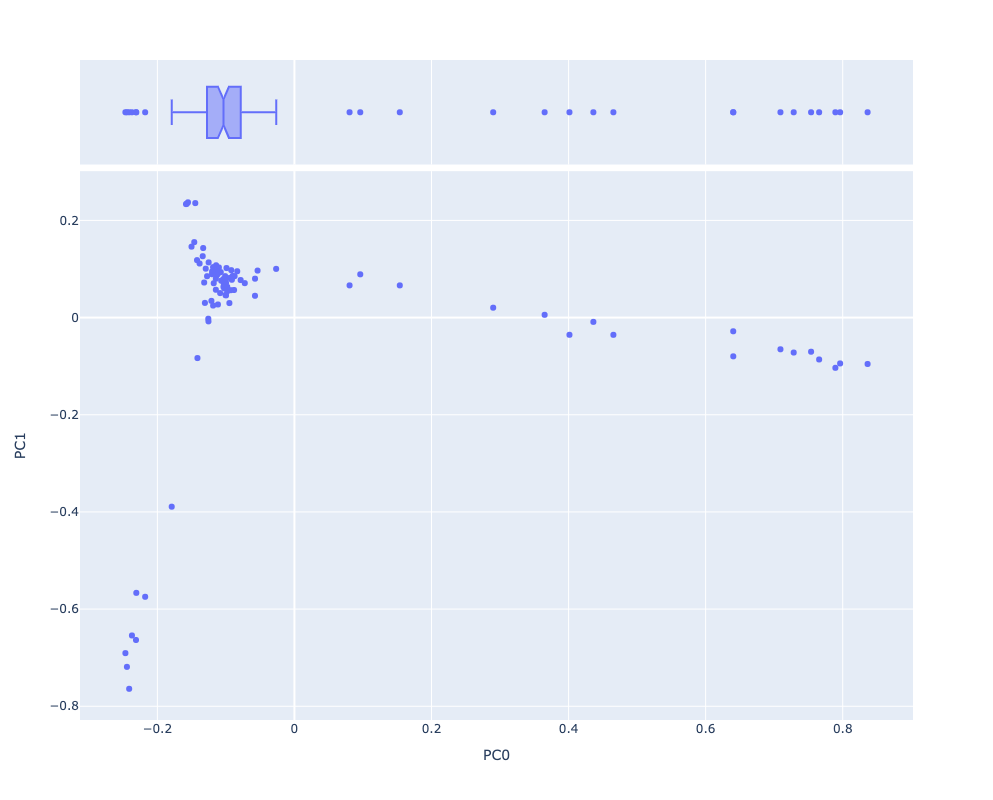

In [259]:
vis_pcs(DCM, 0, 1)

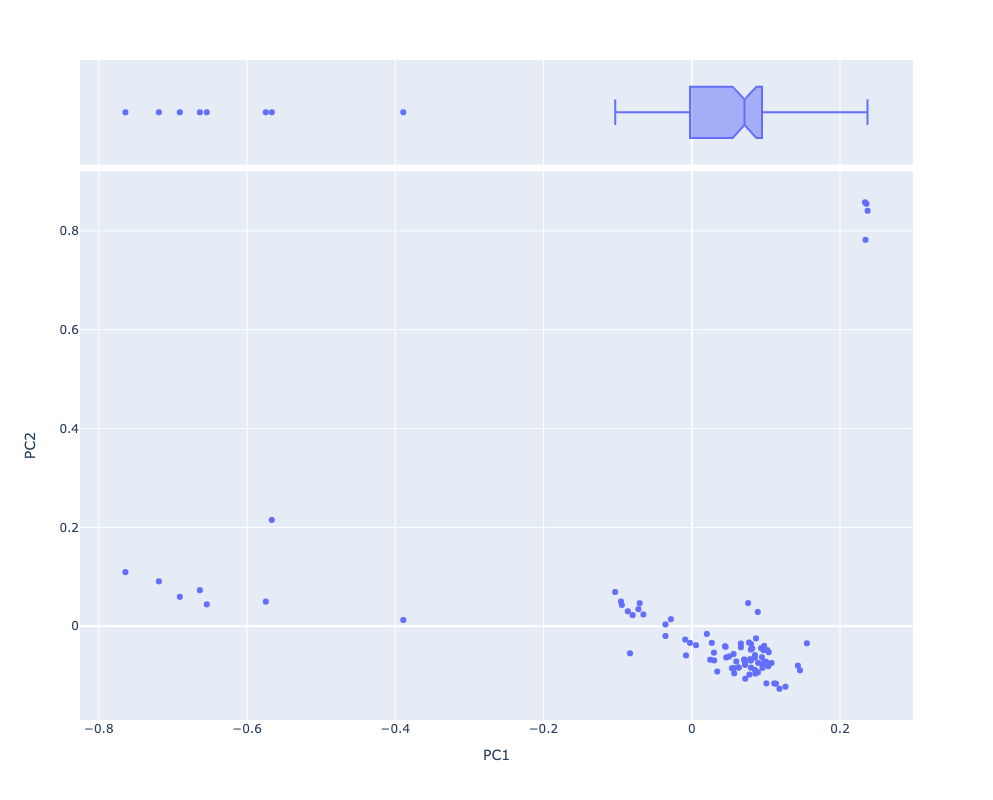

In [102]:
vis_pcs(DCM, 1, 2)

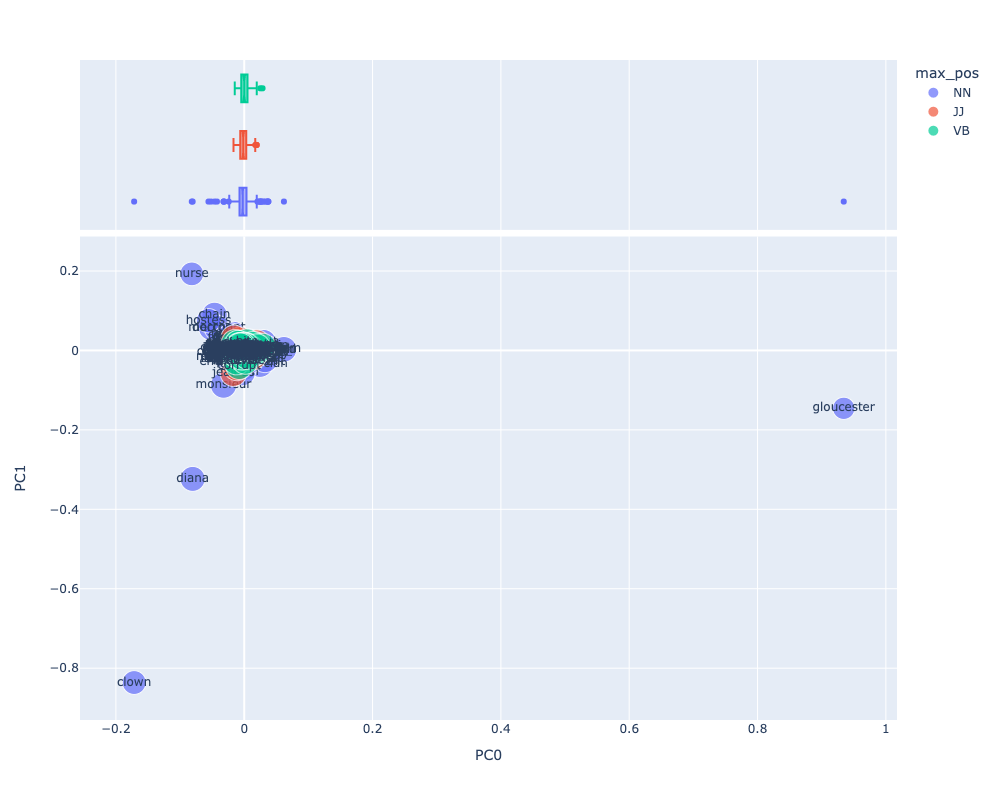

In [103]:
vis_loadings(0,1)

## 6 Topic Modeling/Latent Dirichlet Allocation

### 6.1 Initializing Parameters and Data Manipulation

In [104]:
# Parameters for LDA
ngram_range = [1,2]
n_terms = 4000
n_topics = 20
max_iter = 5
n_top_terms = 7

In [105]:
lda_tokens = TOKENS2.reset_index().drop(['pos_tuple', 'token_str'], axis = 1)
lda_tokens.rename(columns = {'level_4':'token_num'}, inplace = True)

In [106]:
lda_tokens

book_id  act_num  scene_num  sent_num  \
0             ALL’S WELL THAT ENDS WELL      1.0        1.0         0   
1             ALL’S WELL THAT ENDS WELL      1.0        1.0         0   
2             ALL’S WELL THAT ENDS WELL      1.0        1.0         0   
3             ALL’S WELL THAT ENDS WELL      1.0        1.0         0   
4             ALL’S WELL THAT ENDS WELL      1.0        1.0         0   
...                                 ...      ...        ...       ...   
443008  THE TRAGEDY OF ROMEO AND JULIET      5.0       24.0       339   
443009  THE TRAGEDY OF ROMEO AND JULIET      5.0       24.0       339   
443010  THE TRAGEDY OF ROMEO AND JULIET      5.0       24.0       339   
443011  THE TRAGEDY OF ROMEO AND JULIET      5.0       24.0       339   
443012  THE TRAGEDY OF ROMEO AND JULIET      5.0       24.0       340   

        token_num   pos  term_str  
0               0   NNP     enter  
1               1   NNP   bertram  
2               3    DT       the  
3               4   NNP  countess  
4               5    IN        of  
...           ...   ...       ...  
443008         22   NNP    juliet  
443009         23    CC       and  
443010         24  PRP$       her  
443011         25    NN     romeo  
443012          1    NN   _exeunt  

[443013 rows x 7 columns]

In [107]:
# Bag is chapter
bag = ['book_id', 'act_num', 'scene_num']
DOCS = lda_tokens[lda_tokens.pos.str.match(r'^NNS?$')]\
    .groupby(bag).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

#### Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of songs into a document-term vector space of word counts.

In [108]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()
voc = pd.DataFrame(index=TERMS)
voc.index.name = 'term_str'

### 6.2 Generate model

In [109]:
# LDA
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
lda_model1 = lda_engine.fit_transform(count_model)

In [110]:
# Topic names
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

#### 6.21 Theta

In [111]:
THETA = pd.DataFrame(lda_model1, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

#### 6.22 Phi

In [112]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

#### 6.23 Topics

In [113]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])

In [114]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [263]:
TOPICS.sample(5)

term_str          0         1       2       3          4       5          6  \
topic_id                                                                      
T02       cymbeline  belarius  imogen  cloten  guiderius    lord  arviragus   
T17         macduff   malcolm    ross    iago     cassio  duncan     murder   
T00          portia       man    lord   night    theseus    love     brutus   
T15           romeo      thou    thee   night       love  hubert     edmund   
T01            thou       man     sir    thee       love   _exit     juliet   

term_str                                              label  doc_weight_sum  \
topic_id                                                                      
T02       T02 cymbeline, belarius, imogen, cloten, guide...       27.194643   
T17       T17 macduff, malcolm, ross, iago, cassio, dunc...        6.701869   
T00       T00 portia, man, lord, night, theseus, love, b...       15.837459   
T15       T15 romeo, thou, thee, night, love, hubert, ed...       16.723859   
T01           T01 thou, man, sir, thee, love, _exit, juliet       22.897184   

term_str  term_freq  
topic_id             
T02        0.049914  
T17        0.011596  
T00        0.041296  
T15        0.035011  
T01        0.059623

In [116]:
# Seeing topics by book
THETA.reset_index().groupby('book_id').mean().drop(['act_num', 'scene_num'], axis = 1)

T00       T01       T02  \
book_id                                                                    
A MIDSUMMER NIGHT’S DREAM                   0.192897  0.100882  0.000211   
ALL’S WELL THAT ENDS WELL                   0.021569  0.025174  0.000442   
CYMBELINE                                   0.015706  0.005015  0.322008   
THE COMEDY OF ERRORS                        0.000219  0.425848  0.000219   
THE FIRST PART OF HENRY THE SIXTH           0.017420  0.076248  0.204447   
THE FIRST PART OF KING HENRY THE FOURTH     0.039431  0.091805  0.000283   
THE LIFE AND DEATH OF KING JOHN             0.000468  0.000468  0.159065   
THE MERCHANT OF VENICE                      0.115440  0.301085  0.005752   
THE SECOND PART OF KING HENRY IV            0.000250  0.003723  0.000250   
THE SECOND PART OF KING HENRY THE SIXTH     0.015590  0.030535  0.006210   
THE THIRD PART OF KING HENRY THE SIXTH      0.017673  0.023674  0.008367   
THE TRAGEDY OF ANTONY AND CLEOPATRA         0.024328  0.000943  0.138839   
THE TRAGEDY OF HAMLET, PRINCE OF DENMARK    0.099799  0.010525  0.022738   
THE TRAGEDY OF JULIUS CAESAR                0.096654  0.000619  0.000619   
THE TRAGEDY OF KING LEAR                    0.019768  0.049612  0.050415   
THE TRAGEDY OF MACBETH                      0.012044  0.008337  0.030166   
THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE  0.049368  0.011158  0.053666   
THE TRAGEDY OF ROMEO AND JULIET             0.095543  0.133195  0.000431   

                                                 T03       T04       T05  \
book_id                                                                    
A MIDSUMMER NIGHT’S DREAM                   0.000211  0.043064  0.000211   
ALL’S WELL THAT ENDS WELL                   0.043589  0.277291  0.014200   
CYMBELINE                                   0.048456  0.205216  0.022010   
THE COMEDY OF ERRORS                        0.073082  0.000219  0.406840   
THE FIRST PART OF HENRY THE SIXTH           0.008098  0.036241  0.001525   
THE FIRST PART OF KING HENRY THE FOURTH     0.000283  0.218950  0.254858   
THE LIFE AND DEATH OF KING JOHN             0.000468  0.122215  0.000468   
THE MERCHANT OF VENICE                      0.000440  0.066433  0.000623   
THE SECOND PART OF KING HENRY IV            0.000250  0.023552  0.307428   
THE SECOND PART OF KING HENRY THE SIXTH     0.002114  0.087441  0.003542   
THE THIRD PART OF KING HENRY THE SIXTH      0.006292  0.029422  0.000450   
THE TRAGEDY OF ANTONY AND CLEOPATRA         0.051097  0.111247  0.001929   
THE TRAGEDY OF HAMLET, PRINCE OF DENMARK    0.151159  0.033683  0.000273   
THE TRAGEDY OF JULIUS CAESAR                0.000619  0.073780  0.175734   
THE TRAGEDY OF KING LEAR                    0.000464  0.206334  0.005724   
THE TRAGEDY OF MACBETH                      0.000646  0.042386  0.000646   
THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE  0.000509  0.399593  0.000509   
THE TRAGEDY OF ROMEO AND JULIET             0.043107  0.029884  0.000431   

                                                 T06       T07       T08  \
book_id                                                                    
A MIDSUMMER NIGHT’S DREAM                   0.008181  0.109688  0.168970   
ALL’S WELL THAT ENDS WELL                   0.011545  0.000442  0.013956   
CYMBELINE                                   0.050065  0.034372  0.040422   
THE COMEDY OF ERRORS                        0.090722  0.000219  0.000219   
THE FIRST PART OF HENRY THE SIXTH           0.285512  0.000401  0.081567   
THE FIRST PART OF KING HENRY THE FOURTH     0.066522  0.060003  0.044360   
THE LIFE AND DEATH OF KING JOHN             0.107146  0.000468  0.338842   
THE MERCHANT OF VENICE                      0.094474  0.052425  0.000440   
THE SECOND PART OF KING HENRY IV            0.056643  0.035330  0.181866   
THE SECOND PART OF KING HENRY THE SIXTH     0.385140  0.072515  0.251734   
THE THIRD PART OF KING HENRY THE SIXTH      0.357109  0.022123  0.454691   
THE TRAGEDY OF ANTO

### 6.3 Topics by Play

In [118]:
plays = sorted(LIB.reset_index().book_id.value_counts().index.to_list())

In [119]:
# LIB = LIB.reset_index()
# LIB = LIB.drop('index', axis = 1)
# LIB

In [120]:
TOPICS_plays = TOPICS.copy()
TOPICS_plays[plays] = THETA.join(LIB, on=['book_id']).groupby('book_id')[TNAMES].mean().T

In [121]:
TOPICS_plays = TOPICS_plays[plays + ['label']]

In [122]:
TOPICS_plays.head(5)

term_str  A MIDSUMMER NIGHT’S DREAM  ALL’S WELL THAT ENDS WELL  CYMBELINE  \
topic_id                                                                    
T00                        0.192897                   0.021569   0.015706   
T01                        0.100882                   0.025174   0.005015   
T02                        0.000211                   0.000442   0.322008   
T03                        0.000211                   0.043589   0.048456   
T04                        0.043064                   0.277291   0.205216   

term_str  THE COMEDY OF ERRORS  THE FIRST PART OF HENRY THE SIXTH  \
topic_id                                                            
T00                   0.000219                           0.017420   
T01                   0.425848                           0.076248   
T02                   0.000219                           0.204447   
T03                   0.073082                           0.008098   
T04                   0.000219                           0.036241   

term_str  THE FIRST PART OF KING HENRY THE FOURTH  \
topic_id                                            
T00                                      0.039431   
T01                                      0.091805   
T02                                      0.000283   
T03                                      0.000283   
T04                                      0.218950   

term_str  THE LIFE AND DEATH OF KING JOHN  THE MERCHANT OF VENICE  \
topic_id                                                            
T00                              0.000468                0.115440   
T01                              0.000468                0.301085   
T02                              0.159065                0.005752   
T03                              0.000468                0.000440   
T04                              0.122215                0.066433   

term_str  THE SECOND PART OF KING HENRY IV  \
topic_id                                     
T00                               0.000250   
T01                               0.003723   
T02                               0.000250   
T03                               0.000250   
T04                               0.023552   

term_str  THE SECOND PART OF KING HENRY THE SIXTH  \
topic_id                                            
T00                                      0.015590   
T01                                      0.030535   
T02                                      0.006210   
T03                                      0.002114   
T04                                      0.087441   

term_str  THE THIRD PART OF KING HENRY THE SIXTH  \
topic_id                                           
T00                                     0.017673   
T01                                     0.023674   
T02                                     0.008367   
T03                                     0.006292   
T04                                     0.029422   

term_str  THE TRAGEDY OF ANTONY AND CLEOPATRA  \
topic_id                                        
T00                                  0.024328   
T01                                  0.000943   
T02                                  0.138839   
T03                                  0.051097   
T04                                  0.111247   

term_str  THE TRAGEDY OF HAMLET, PRINCE OF DENMARK  \
topic_id                                             
T00                                       0.099799   
T01                                       0.010525   
T02                                       0.022738   
T03                                       0.151159   
T04                                       0.033683   

term_str  THE TRAGEDY OF JULIUS CAESAR  THE TRAGEDY OF KING LEAR  \
topic_id                                                           
T00                           0.096654                  0.019768   
T01                           0.000619                  0.049612   
T02                           0.000619                  0.050415 

## 7 Word2Vec

### 7.1 Setting Parameters and Data Wrangling

In [123]:
w2v_params = dict(
    window = 2,
    vector_size = 256,
    min_count = 50,
    workers = 4
)

In [124]:
DOCS = TOKENS2\
    .groupby(bag)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

### 7.2 Model Construction

In [125]:
model = word2vec.Word2Vec(DOCS, **w2v_params)

In [126]:
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.key_to_index], 
        term_str = model.wv.key_to_index.keys()
    )).set_index('term_str')

In [127]:
tsne_engine = TSNE(learning_rate = 200,perplexity=20, n_components=2, init='random', n_iter=1000, random_state=69)
tsne_shakespeare = tsne_engine.fit_transform(coords.vector.to_list())

In [128]:
coords['x'] = tsne_shakespeare[:,0]
coords['y'] = tsne_shakespeare[:,1]

In [129]:
VOCAB['pos_group'] = VOCAB['max_pos'].str[:2]
vocab_subset = VOCAB[(VOCAB['pos_group'] == 'NN') | (VOCAB['pos_group'] == 'VB')]

In [130]:
if coords.shape[1] == 3:
    coords = coords.merge(vocab_subset.reset_index(), on='term_str')
    coords = coords.set_index('term_str')

In [131]:
coords['nlog'] = np.log(coords.n)

### 7.3 Plotting

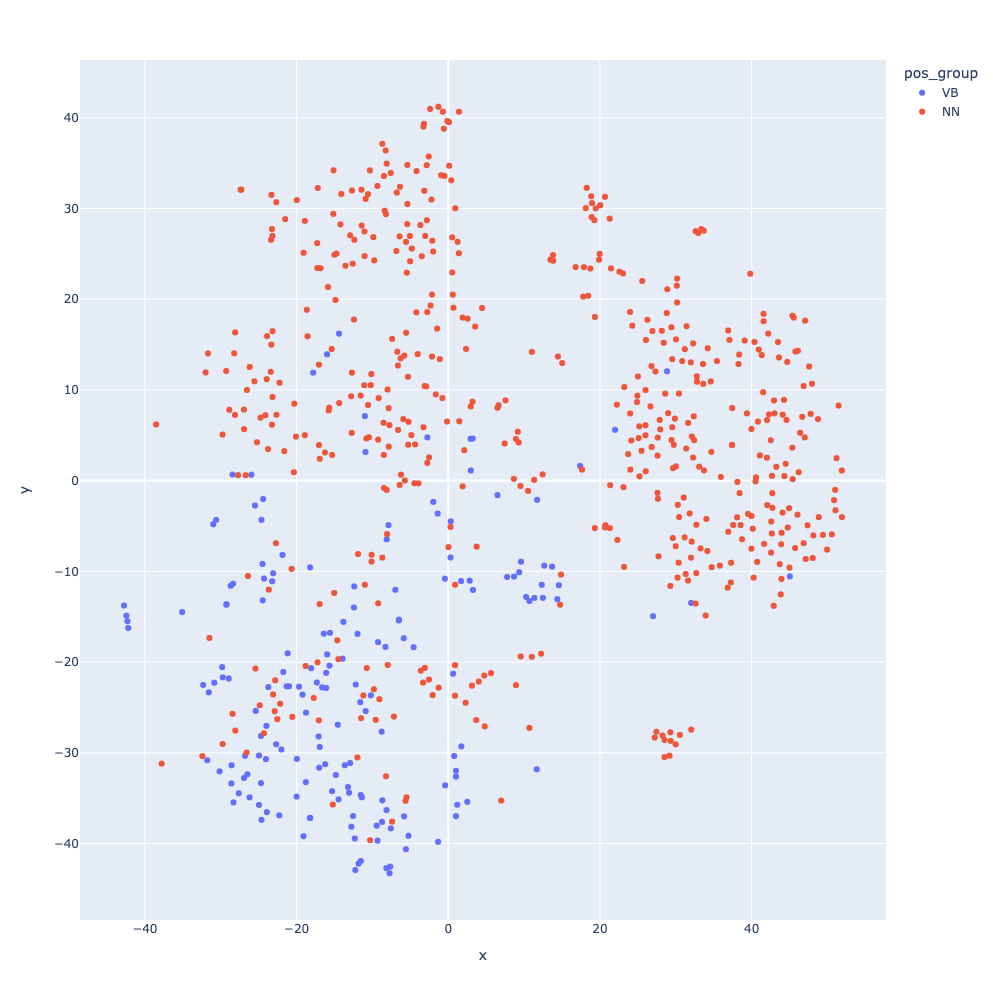

In [132]:
warnings.filterwarnings("ignore")
px.scatter(coords.reset_index(), 'x', 'y', 
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

### 7.4 Analogies!

In [133]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

##### Pretty impressive; Romeo:Juliet::Othello:? gives Desdemona as top result!

In [265]:
complete_analogy('romeo', 'juliet', 'othello', 3)

term       sim
0  desdemona  0.925454
1     helena  0.918784
2     emilia  0.913511

##### This one is also very impressive; Macbeth:Macbeth::Othello:? gives Iago as top result. I intended this to be interpreted as Macbeth (title of play) to Macbeth (villain of play), so Iago is in fact the correct answer here.

In [266]:
complete_analogy('macbeth', 'macbeth', 'othello', 3)

term       sim
0  desdemona  0.955634
1     emilia  0.949708
2  cleopatra  0.945487

## 8 Sentiment Analysis

In [136]:
salex_csv = pd.read_csv('~/Documents/GitHub/E_Text_Analytics/DS5001-2023-01-R/salex_nrc.csv')
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [137]:
BOW_ACTS

n
book_id                         act_num term_str    
A MIDSUMMER NIGHT’S DREAM       1.0     _exeunt    2
                                        _exit      4
                                        _the       1
                                        a         49
                                        abjure     1
...                                               ..
THE TRAGEDY OF ROMEO AND JULIET 5.0     youth      4
                                        —          5
                                        —here      1
                                        —which     1
                                        —with      1

[113668 rows x 1 columns]

In [138]:
SALEX = salex_csv.set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative

In [139]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  polarity  
term_str                                         
abandon            1         0      0        -1  
abandoned          1         0      0        -1  
abandonment        1         1      0        -1  
abduction          1         1      0        -1  
aberration         0         0      0        -1  
...              ...       ...    ...       ...  
young              0         1      0         1  
youth              0         1      0         1  
zeal               0         1      1         1  
zealous            0         0      1         1  
zest               0         0      1         1  

[3688 rows x 11 columns]

In [140]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1) #\
    # .reset_index().set_index('term_id')

In [141]:
B = BOW_SCENES.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [269]:
EMBEDDINGS = V

In [142]:
BOW_BOOKS

n        tf     tfidf
book_id                         term_str                        
A MIDSUMMER NIGHT’S DREAM       _as        1  0.000058  0.000149
                                _dies      2  0.000115  0.000067
                                _exeunt   16  0.000921  0.000000
                                _exit     30  0.001727  0.000000
                                _giving    1  0.000058  0.000091
...                                       ..       ...       ...
THE TRAGEDY OF ROMEO AND JULIET —which     1  0.000038  0.000160
                                —who       1  0.000038  0.000121
                                —why       1  0.000038  0.000083
                                —with      1  0.000038  0.000160
                                —you       1  0.000038  0.000061

[65252 rows x 3 columns]

In [144]:
# Scale by TFIDF
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [146]:
EMO_SCENES = B.groupby(['book_id','act_num', 'scene_num'])[emo_cols].mean()

#### Comparing a few plays, interesting to see Romeo and Juliet scoring so "positively" in terms of emotions

In [157]:
list_of_works

['ALL’S WELL THAT ENDS WELL',
 'THE TRAGEDY OF ANTONY AND CLEOPATRA',
 'THE COMEDY OF ERRORS',
 'CYMBELINE',
 'THE TRAGEDY OF HAMLET, PRINCE OF DENMARK',
 'THE FIRST PART OF KING HENRY THE FOURTH',
 'THE SECOND PART OF KING HENRY IV',
 'THE FIRST PART OF HENRY THE SIXTH',
 'THE SECOND PART OF KING HENRY THE SIXTH',
 'THE THIRD PART OF KING HENRY THE SIXTH',
 'THE LIFE AND DEATH OF KING JOHN',
 'THE TRAGEDY OF JULIUS CAESAR',
 'THE TRAGEDY OF KING LEAR',
 'THE TRAGEDY OF MACBETH',
 'THE MERCHANT OF VENICE',
 'A MIDSUMMER NIGHT’S DREAM',
 'THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE',
 'THE TRAGEDY OF ROMEO AND JULIET']

In [185]:
RAJ = EMO_SCENES.loc['THE TRAGEDY OF ROMEO AND JULIET'].copy()
OTHELLO = EMO_SCENES.loc['THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE'].copy()
MACBETH = EMO_SCENES.loc['THE TRAGEDY OF MACBETH'].copy()
COE = EMO_SCENES.loc['THE COMEDY OF ERRORS'].copy()

In [186]:
RAJ = RAJ.reset_index()
OTHELLO = OTHELLO.reset_index()
MACBETH = MACBETH.reset_index()
COE = COE.reset_index()

In [187]:
RAJ[['act_num' , 'scene_num']] = RAJ[['act_num' , 'scene_num']].astype(int)
OTHELLO[['act_num' , 'scene_num']] = OTHELLO[['act_num' , 'scene_num']].astype(int)
MACBETH[['act_num' , 'scene_num']] = MACBETH[['act_num' , 'scene_num']].astype(int)
COE[['act_num' , 'scene_num']] = COE[['act_num' , 'scene_num']].astype(int)

In [188]:
RAJ.set_index(['act_num', 'scene_num'], inplace= True)
OTHELLO.set_index(['act_num', 'scene_num'], inplace= True)
MACBETH.set_index(['act_num', 'scene_num'], inplace= True)
COE.set_index(['act_num', 'scene_num'], inplace= True)

In [189]:
RAJ.style.background_gradient(cmap='YlGnBu', axis=None)

Romeo and Juliet kill themselves in the last scene, so it's weird that sadness isn't more significant in that scene.

In [190]:
OTHELLO.style.background_gradient(cmap='YlGnBu', axis=None)

The second scene of Act 2 (scene 5 overall) is when Othello announces the war victory. It is a highly triumphant part of the book. 

Act 3, scene 2 (scene 8 overall) is when Othello gives letters to Iago, indicating his trust. THerefore, it registers highly in Trust.

In [191]:
MACBETH.style.background_gradient(cmap='YlGnBu', axis=None)

The first scene involves three witches plotting to meet Macbeth.

Act 3, Scene 3 is when Macbeth has Banquo killed, so it scores highly in anger, disgust, fear, and sadness.

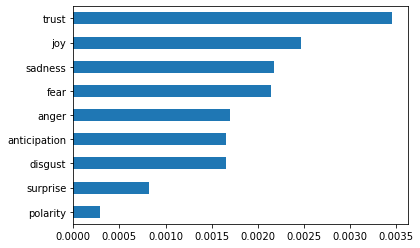

In [155]:
RAJ.mean().sort_values().plot.barh();

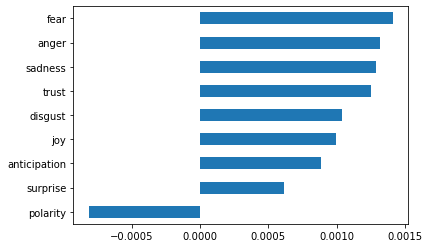

In [156]:
COE.mean().sort_values().plot.barh();

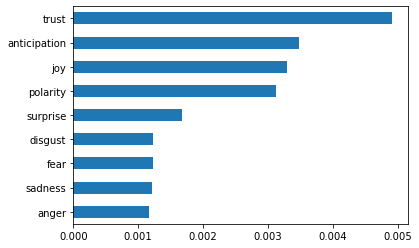

In [159]:
OTHELLO.mean().sort_values().plot.barh();

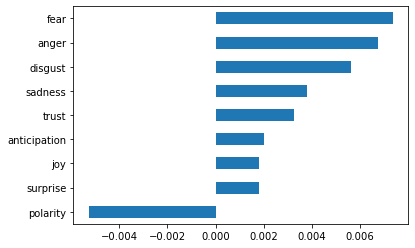

In [160]:
MACBETH.mean().sort_values().plot.barh();

In [193]:
RAJ_scenes_thin = EMO_SCENES.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == 'THE TRAGEDY OF ROMEO AND JULIET'")
Macbeth_scenes_thin= EMO_SCENES.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == 'THE TRAGEDY OF MACBETH'")

In [194]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

### 9 Exporting CSV's

In [271]:
# LIB
LIB.to_csv('Project_LIB.csv', index = True)

In [273]:
# CORPUS
CORPUS.to_csv('Project_CORPUS.csv', index = True)

In [274]:
# VOCAB
VOCAB.to_csv('Project_VOCAB.csv', index = True)

In [275]:
# PAIRS
PAIRS.to_csv('Project_PAIRS.csv', index = True)

In [276]:
# TOPICS_plays
TOPICS_plays.to_csv('Project_TOPICS_plays.csv', index = True)

In [277]:
# LOADINGS
LOADINGS.to_csv('Project_LOADINGS.csv', index = True)

In [279]:
# EMBEDDINGS
EMBEDDINGS.to_csv('Project_EMBEDDINGS.csv', index = True)